# Transitional Dynamics

(If GitHub truncates the output, you can see the full rendering in Google Colab:
Clink [here](https://nbviewer.org/github/Kanato-Nakakuni/ComputationalMacro/blob/main/Lec07_Transition.ipynb).)

- We have learned how to compute the long-run equilibrium in response to an exogenous change in the economic environment (e.g., changes in policy, technology, or preferences)  

- But we do not yet know what happens along the transitional dynamics, during which the economy reaches to the new equilibrium  

- **Question:** *What does the transition to the new long-run equilibrium look like?*  
  - It takes time for the economy to reach the new equilibrium  
  - Short- or medium-run effects may differ from the long-run effects, which is critical for the welfare of different generations/cohorts  

- **Goal of this lecture:** Understand how to solve the transitional dynamics and be able to implement them
 
---

### Model Setup
- To focus on the essence of the computational algorithm for transitional dynamics, we use a simple yet meaningful example:  

  - A two-period model with exogenous labor supply, parental investments, and endogenous human capital.  

---
### Household
- Problem:

$$
\max_{c^y_t,c^o_{t+1},e_t} ~ \ln(c^y_t) + \gamma\ln(h_{t+1}) + \beta\ln(c^o_{t+1})
$$
subject to:
$$
c^y_t + (1-s_t)p_e e_t + a_{t+1} = (1-\tau_t)w_t h_t\\
c^o_{t+1} = (1+r_{t+1})a_{t+1} \\
h_{t+1} = H(e_t) = \theta + B e_t^\kappa \\
$$

- $e_t$: money spent in children's education  

- $p_e$: price of the investment goods  

- $s_t$: subsidy rate of educational investments  

- $H(e_t)$: human capital production function with parameters $(\theta, B, \kappa)$  

- The older (parent) generation gains utility from the quality of children $h_{t+1}$  

---

### Firm  

- Production function:
$$
    F(K_t,N_t)=K_t^{\alpha}N_t^{1-\alpha}
$$

- $N_t=h_t\mu^y_t$: labor supply exogenous but human capital endogenous  

- $\mu^y_t$: population mass of young generation in year $t$

- Capital market clearing implies that $K_t=a_{t+1}\mu^y_t$  

---
### Government

- Tax rate $\tau_t$ is determined so that it satisfies government budget constraint:

$$
\tau_t w_t h_t \mu^y_t = s_t p_e e_t \mu^y_t
$$

---
### Equilibrium conditions

- In equilibrium, prices are given as:
$$
r_t = \alpha (K_t/N_t)^{\alpha-1} 
$$
and
$$
w_t = (1-\alpha) (K_t/N_t)^{\alpha}
$$

- Government budget constraint is satisfied:
$$
\tau_t = \frac{s_t p_e e_t}{w_t h_t}
$$

- In stationary equilibrium, human capital level is constant across generations: $h_t=h_{t+1}$ for any $t$.

---

### Algorithm  
0. Solve for a new stationary equilibrium (e.g., with a new parameter $s=0.5$).  
<br>
1. Set the duration of the transition, $T$, such that the economy reaches the new equilibrium (at the latest) after $T$ periods have passed.  
<br>
2. Make initial guesses for the equilibrium prices and the tax rate along the transition path.  
<br>
3. Solve the household problem for each cohort along the transition, given the guessed prices and tax rate.  
<br>
4. Compute the aggregate quantities (output, capital, and labor supply) implied by household behavior, as well as the corresponding prices and tax rate, for each $t = 0, 1, \dots, T$.  
<br>
5. Check whether the guessed prices and tax rate are sufficiently close to the implied values for each $t$. If not, update the guesses and return to Step 3 until convergence. 

---

### Procedure  

Today's focus is on the algorithm for solving the transitional dynamics and its implementation. Taking the following functions and steps as given, let’s move straight to Step 4 and try to solve the transition.  

1. Prepare a struct `Params` that contains $(\beta,\gamma,p_e,\theta,B,\kappa,\alpha,s)$.  

2. Prepare a function `household` that returns the optimal $(c^y,c^o,e)$, taking as inputs human capital $h$, prices $(r,w,\tau)$, and the parameter structure $p$ (=`Params`).  

3. Prepare a function `solve_stationary` that solves for the stationary equilibrium and returns the equilibrium outcomes $(r,w,\tau,Y,K,N)$, taking as inputs the initial guesses for prices and tax rate, and parameters, as well as the initial guess for human capital. In doing so, also prepare a function `fixed_point_h` that computes the stationary human capital $h$ (i.e., fixed point for $h$), taking as inputs prices, the tax rate, parameters, and the initial guess for human capital.  

4. Solve the transition based on the algorithm presented above.  

---

In [1]:
# step 1: parameter structure
struct Params{F<:Float64}
    β::F # time discount
    γ::F # weight on quality
    p_e::F # education price
    θ::F # parameter on human capital production (intercept)
    B::F # parameter on human capital production (slope)
    κ::F # parameter on human capital production (curvature)
    α::F # capital share
    s::F # education subsidy rate
end

In [2]:
# function to solve household problem
using Roots # we will learn the algorithm for root finding as well in Lecture 9.

function household(h,w,r,τ,p)

    # retrieve parameters
    β=p.β
    γ=p.γ
    θ=p.θ
    B=p.B
    κ=p.κ
    p_e=p.p_e
    s=p.s

    # step 1. guess c0
    c0 = 0.5
    c1 = 0.0
    e  = 0.0

    d=1.0
    ε=1.e-5
    iter=1
    maxiter=10000
    adj=0.001

    while (d>ε && iter<maxiter)

        # step 2. compute the implied allocation based on guessed c0
            # pin down c1 from the FOC
            c1 = β*(1+r)*c0

            # find optimal e given c0
            f(e) = γ/(θ+B*e^κ) * B*κ*e^(κ-1) - (1-s)*p_e/c0
            e = find_zero(f, (1e-6, 10.0))

        # step 3. check if the implied allocation satisfies budget constraint with equality
        spending = c0 + (1-s)*p_e*e + c1/(1+r)
        income = (1-τ)*w*h

        d=abs(spending-income)

        # step 4. update
        if (d>ε)
            if (spending>income) # c0 needs to be lower
                c0=(1-adj)*c0
            else # c0 needs to be higher
                c0=(1+adj)*c0
            end
            iter+=1
        end
    end
    
    return c0,c1,e
end

household (generic function with 1 method)

In [3]:
# function to find the stationary h
function fixed_point_h(h0,w,r,τ,p)

    # retrieve parameters regarding human capital production
    θ=p.θ
    B=p.B
    κ=p.κ

    # step 1: guess h
    # h0: initial guess
    h = h0

    adj=0.5
    d=1.0
    ε=1.e-5
    iter=1
    maxiter=10000

    while (d>ε && iter<maxiter)
    
        # step 2: compute implied h
        c0,c1,e = household(h,w,r,τ,p)
        imp_h = θ + B*e^κ

        d = abs(h-imp_h)

        if (d>ε)
            h=adj*imp_h+(1.0-adj)*h
            iter+=1
        end

    end    

    return h
    
end

fixed_point_h (generic function with 1 method)

In [4]:
# function to solve stationary equilibrium
function solve_stationary(h0,w0,r0,τ0,p)

    # retrieve relevant parameters
    α=p.α
    s=p.s
    p_e=p.p_e

    w=w0
    r=r0
    τ=τ0

    # for output
    K=0.0
    N=0.0
    Y=0.0

    adj=0.5
    d=1.0
    ε=1.e-4
    iter=1
    maxiter=1000

    while (d>ε  && iter<maxiter)

        # solve equilibrium allocations given prices and tax
        h = fixed_point_h(h0,w,r,τ,p)
        c0,c1,e = household(h,w,r,τ,p)

        K = c1/(1+r)
        N = h
        Y = K^α * N^(1-α)

        imp_r = α*(K/N)^(α-1)
        imp_w = (1-α)*(K/N)^α
        imp_τ=(s*p_e*e)/(w*h)

        d = max(abs(r-imp_r),abs(w-imp_w),abs(τ-imp_τ))
        if (d>ε)
            # update
            r = adj*imp_r + (1-adj)*r
            w = adj*imp_w + (1-adj)*w
            τ = adj*imp_τ + (1-adj)*τ

            h0=h

            iter+=1
        end

        # @show iter,d

    end

    return w,r,τ,Y,K,N # prices (w,r,τ) and quantities (Y,K,N)
end

solve_stationary (generic function with 1 method)

In [7]:
# Transition
# assume the mass of young generation is constant and is normalized to one.

# parameters
β=0.8
γ=1.0
p_e=1.0
θ=0.2
B=0.9
κ=0.5
α=0.33
s = 0.0

s_old=0.0
s_new=0.1

p = Params(β,γ,p_e,θ,B,κ,α,s)

# step 0. solve initial and final stationary equilibria (steady states)
    # initial economy
    h=1.0; w=1.0; r=0.2; τ=0.0; # initial guesses
    w0,r0,τ0,Y0,K0,N0=solve_stationary(h,w,r,τ,p)
    # new equilibrium (use equilibrium objects in initial economy for initial guesses)
    # consider introducing 10% education-subsidy
    s = s_new
    p = Params(β,γ,p_e,θ,B,κ,α,s)
    w1,r1,τ1,Y1,K1,N1=solve_stationary(N0,w0,r0,τ0,p)

# step 1. Set the duration of the transition
    T = 8

# step 2. make initial guesses for prices and tax
    s_t=zeros(T); s_t[1]=s_old; s_t[2:T].=s_new;

    # guess linear transition
    r_t = collect(LinRange(r0,r1,T)) 
    w_t = collect(LinRange(w0,w1,T))
    τ_t = collect(LinRange(τ0,τ1,T)) 

    # for output
    K_t = collect(LinRange(K0,K1,T)); K_t[2]=K0;
    N_t = collect(LinRange(N0,N1,T)); N_t[2]=N0;
    Y_t = collect(LinRange(Y0,Y1,T)); Y_t[2]=Y0;

    d_vec = zeros(T) # to stock dif

    d=1.0
    ε=1.e-5
    iter=1
    maxiter=100

    while (d>ε && iter<maxiter)

        # step 3. solve household problem of each cohort, given guessed sequences
        for t in 2:(T-1) # t=1 is the initial steady state, policy changes in t=2.
            r=r_t[t]; w=w_t[t]; τ=τ_t[t]; s=s_t[t];
            p = Params(β,γ,p_e,θ,B,κ,α,s) # update p with new s

            if (t==2) # in t=2, still human capital and asset remain the same as in the initial economy
                N=N0
            else
                N=N_t[t]
            end
            
            c0,c1,e = household(N,w,r,τ,p)
            h_next = θ+B*e^κ

            K = c1/(1+r)

            imp_r = α*(K/N)^(α-1)
            imp_w = (1-α)*(K/N)^α
            imp_τ=(s_t[t]*p_e*e)/(w*N)

            d_vec[t] = maximum((abs(r_t[t]-imp_r),abs(w_t[t]-imp_w),abs(τ_t[t]-imp_τ)))

            # step 5: update
            r_t[t] = (r_t[t]+imp_r)/2.0
            w_t[t] = (w_t[t]+imp_w)/2.0
            τ_t[t] = (τ_t[t]+imp_τ)/2.0

            K_t[t]=K
            N_t[t+1]=h_next
            Y_t[t]=K^α * N^(1-α)


        end

        
        d = maximum(d_vec)
        
        iter+=1

    end

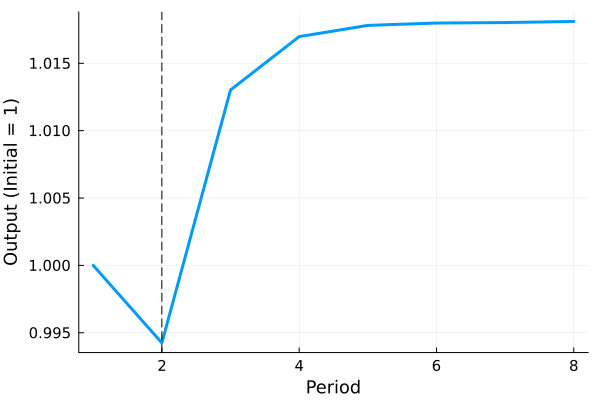

In [8]:
using Plots
# OUTPUT
plot(1:T,Y_t./Y_t[1];
legend=false,
xlabel="Period",                   
ylabel="Output (Initial = 1)",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

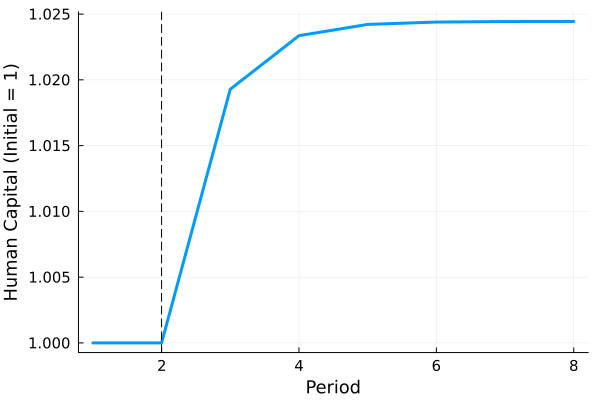

In [9]:
# HUMAN CAPITAL
plot(1:T,N_t./N_t[1];
legend=false,
xlabel="Period",                   
ylabel="Human Capital (Initial = 1)",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

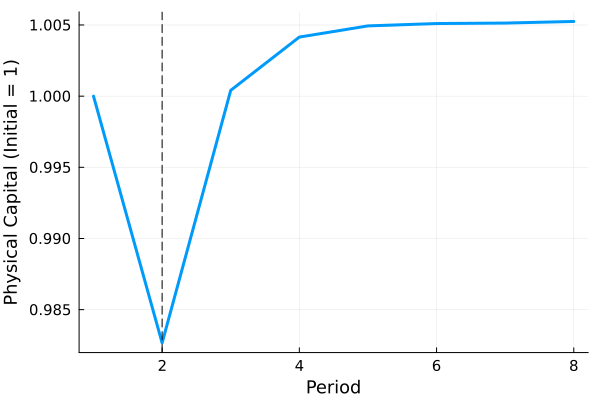

In [10]:
# Physical capital
plot(1:T,K_t./K_t[1];
legend=false,
xlabel="Period",                   
ylabel="Physical Capital (Initial = 1)",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")